In [1]:
import pyhf

import cabinetry.fit as fit
import cabinetry.visualize as viz

import numpy as np
import jax

import matplotlib.pyplot as plt

ERROR! Session/line number was not unique in database. History logging moved to new session 32


In [ ]:
%pip install cabinetry

In [2]:
def make_model(s, b, bup, bdn):
    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": [s],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": [b],
                        "modifiers": [
                            {
                                "name": "bkguncrt",
                                "type": "histosys",
                                "data": {"hi_data": [bup], "lo_data": [bdn]},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(m)

In [3]:
class GaussianModel:
    def __init__(self, cov):
        self.cov = cov

    def logpdf(self, p, d):
        return jax.scipy.stats.multivariate_normal.logpdf(d, p, self.cov).reshape(1)

    def sample(self, key, at, shape):
        return jax.random.multivariate_normal(key, at, self.cov, shape=shape)


class BestFit:
    def __init__(self, bestfit):
        self.bestfit = bestfit

In [4]:
def evaluate_model(m, d, reference):
    grid = xi, yi = np.mgrid[0:4:51j, -2:2:51j]
    X = np.swapaxes(grid, 0, -1).reshape(-1, 2)
    r = jax.vmap(m.logpdf, in_axes=(0, None))(X, d)
    zi = -2 * (r[:, 0].reshape(51, 51).T - m.logpdf(reference, d))
    return xi, yi, zi


def gaussian_approx(m, at):
    mcov = jax.numpy.linalg.inv(jax.hessian(lambda p: -m.logpdf(p, d))(at))[0]
    ggm = GaussianModel(mcov)
    return ggm


def plot_model(axarr, m, d, fr=None, lines=[1, 2, 4]):
    import numpy as np
    import matplotlib.pyplot as plt
    import jax

    fr, ggm, metrics = get_metrics(m, d)

    mcov = jax.numpy.linalg.inv(jax.hessian(lambda p: -m.logpdf(p, d))(fr.bestfit))[0]

    dpoi, dnp = np.sqrt(np.diag(mcov))
    print(dpoi, dnp)

    ax = axarr[0]
    xi, yi, zi = evaluate_model(m, d, fr.bestfit)
    ax.contour(xi, yi, zi, levels=lines, colors="k")

    xi, yi, zi = evaluate_model(ggm, fr.bestfit, fr.bestfit)
    ax.contour(xi, yi, zi, levels=lines, colors="r")

    ax.scatter(
        fr.bestfit[0],
        fr.bestfit[1],
        c="r",
    )
    ax.errorbar(fr.bestfit[0], fr.bestfit[1], yerr=[dnp], xerr=[dpoi], c="r")
    ax.set_xlim(xi.min() - 0.2, xi.max())

    ax = axarr[1]
    ax.bar(range(4), metrics, alpha=0.2)
    ax.set_ylim(0.005, 10)
    ax.set_yscale("log")
    ax.grid()
    ax.set_xticks(range(4))
    ax.set_xticklabels(["cls", "gaussian", "s_POI", "(s_NP-1)^2"])
    return metrics

In [5]:
def get_gaussianity_metrics(m, at):
    GA = gaussian_approx(m, at=at)
    samps = GA.sample(key=key, at=at, shape=(100,))
    m_nll = -jax.vmap(
        lambda p, d: -(m.logpdf(p, d) - m.logpdf(at, d)), in_axes=(0, None)
    )(samps, d)[:, 0]
    ga_nll = -jax.vmap(
        lambda p, d: -(GA.logpdf(p, d) - GA.logpdf(at, d)), in_axes=(0, None)
    )(samps, at)[:, 0]
    diffs = (m_nll - ga_nll) ** 2
    diffs = diffs[np.isfinite(diffs)]
    return GA, diffs.mean()


def get_metrics(m, d):
    import jax

    pyhf.set_backend("jax", pyhf.optimize.scipy_optimizer())
    widths = np.diag(
        np.sqrt(
            jax.numpy.linalg.inv(
                jax.hessian(lambda p: -m.logpdf(p, d)[0])(np.array([0.0, 0.0]))
            )
        )
    )
    cls_obs = pyhf.infer.hypotest(1.0, d, m, init_pars=[0.0, 0.0])

    fr = BestFit(pyhf.infer.mle.fit(d, m))
    ga_model, gaussianity = get_gaussianity_metrics(m, at=fr.bestfit)

    widths = np.array(widths)
    widths[1] = (widths[1] - 1.0) ** 2
    a = np.array([cls_obs, gaussianity])
    return fr, ga_model, np.concatenate([a, widths])

NameError: name 'fr' is not defined

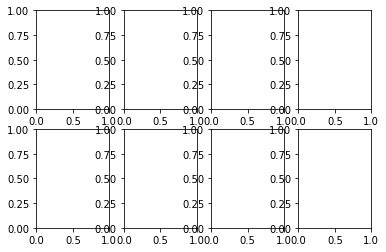

In [6]:
f, axarr = plt.subplots(2, 4)

m = pyhf.simplemodels.correlated_background([10, 0], [50, 50], [30, 30], [30, 30])
d = [50, 50] + m.config.auxdata
metrics = plot_model(axarr[:, 0], m, d, fr, lines=[1, 2, 4])


m = pyhf.simplemodels.correlated_background([10, 0], [50, 50], [50, 40], [50, 60])
d = [50, 50] + m.config.auxdata
metrics = plot_model(axarr[:, 1], m, d, fr, lines=[1, 2, 4])

m = pyhf.simplemodels.correlated_background([4, 4], [50, 50], [60, 60], [40, 40])
d = [50, 50] + m.config.auxdata
metrics = plot_model(axarr[:, 2], m, d, fr, lines=[1, 2, 4])

m = pyhf.simplemodels.correlated_background([10, 0], [50, 50], [50, 53], [50, 47])
d = [50, 50] + m.config.auxdata
metrics = plot_model(axarr[:, 3], m, d, fr, lines=[1, 2, 4])

f.set_size_inches(15, 4)
f.set_tight_layout(True)

0.2363792407497414 0.8407735688751858
0.23624976928744734 1.0


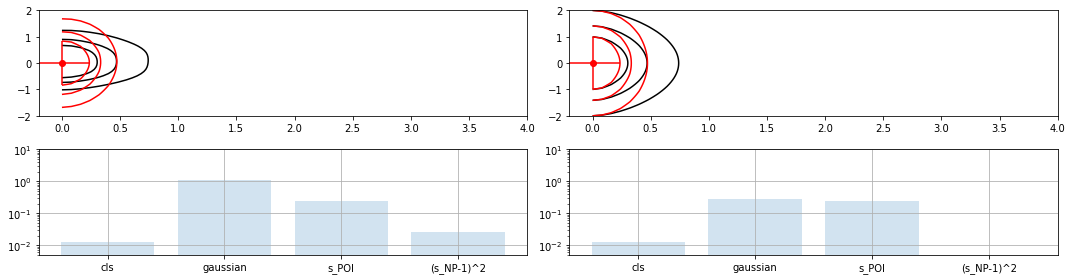

In [259]:
f, axarr = plt.subplots(2, 2)

m = pyhf.simplemodels.correlated_background(
    [1, 1, 3, 4], [20, 15, 5, 1], [15, 15, 5, 1], [15, 20, 5, 1]
)
d = [20, 15, 5, 1] + m.config.auxdata
metrics = plot_model(axarr[:, 0], m, d, fr, lines=[1, 2, 4])


m = pyhf.simplemodels.correlated_background(
    [1, 1, 3, 4], [20, 15, 5, 1], [20, 15, 5, 1], [20, 15, 5, 1]
)
d = [20, 15, 5, 1] + m.config.auxdata
metrics = plot_model(axarr[:, 1], m, d, fr, lines=[1, 2, 4])

f.set_size_inches(15, 4)
f.set_tight_layout(True)

<BarContainer object of 4 artists>

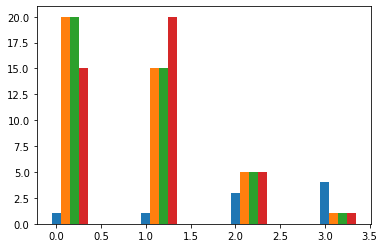

In [256]:
counts = np.array([[1, 1, 3, 4], [20, 15, 5, 1], [20, 15, 5, 1], [15, 20, 5, 1]])
plt.bar(np.arange(4), counts[0], width=0.1)
plt.bar(np.arange(4) + 0.1, counts[1], width=0.1)
plt.bar(np.arange(4) + 0.2, counts[2], width=0.1)
plt.bar(np.arange(4) + 0.3, counts[3], width=0.1)